[View in Colaboratory](https://colab.research.google.com/github/albertorb/mulcia-tfm-nuclei/blob/master/tfm.ipynb)

# Nuclei segmentation: A deep learning approach
### Technology stack


*   Keras (Tensorflow-gpu backend)


## Getting data

In [1]:
!pip install -q keras tqdm

!rm *.pbz2
!wget https://s3-eu-west-1.amazonaws.com/nuclei-tfm/nuclei/test.pbz2
!wget https://s3-eu-west-1.amazonaws.com/nuclei-tfm/nuclei/test_256_normalized.pbz2
!wget https://s3-eu-west-1.amazonaws.com/nuclei-tfm/nuclei/train_256_normalized.pbz2
!wget https://s3-eu-west-1.amazonaws.com/nuclei-tfm/nuclei/labeled_256_normalized.pbz2

--2018-06-08 18:39:12--  https://s3-eu-west-1.amazonaws.com/nuclei-tfm/nuclei/test.pbz2
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.84.58
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.84.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3002047 (2.9M) [binary/octet-stream]
Saving to: ‘test.pbz2’

test.pbz2           100%[===================>]   2.86M  1.09MB/s    in 2.6s    

2018-06-08 18:39:15 (1.09 MB/s) - ‘test.pbz2’ saved [3002047/3002047]

--2018-06-08 18:39:17--  https://s3-eu-west-1.amazonaws.com/nuclei-tfm/nuclei/test_256_normalized.pbz2
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.20.124
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.20.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3559564 (3.4M) [binary/octet-stream]
Saving to: ‘test_256_normalized.pbz2’

test_256_normalized 100%[===============

In [2]:
from bz2 import BZ2File
import _pickle as pickle
import keras
import pylab as plt
import pandas as pd
import numpy as np
from scipy import misc
from collections import Counter
from copy import copy
import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
warnings.filterwarnings('ignore', category=UserWarning, module='keras')

Using TensorFlow backend.


In [3]:
#@title Get data { vertical-output: true, display-mode: "form" }
image_size = 256 #@param ["256", "128"] {type:"raw"}
def get_data(im_size):
  """
  """
  with BZ2File('train_%i_normalized.pbz2' %im_size, 'r') as f:
    train = pickle.load(f)
    train = pd.DataFrame(train, columns=["ImageId", "Pixels"]) 
   
  with BZ2File('labeled_%i_normalized.pbz2' %im_size, 'r') as f:
    labels = pickle.load(f)
    
  with BZ2File('test_%i_normalized.pbz2' %im_size, 'r') as f:
    test = pickle.load(f)  
    test = pd.DataFrame(test, columns=["ImageId", "Pixels"])
  
  test_ids = test.ImageId.values
  X_train = [np.reshape(v.flatten(), (im_size,im_size,3)).astype(np.float32) for v in train.Pixels.values]
  Y_train = [np.reshape(v.flatten(), (im_size,im_size,1)).astype(np.float32) for v in labels]
  test = [np.reshape(v.flatten(), (im_size,im_size,3)).astype(np.float32) for v in test.Pixels.values]
  
  return X_train, Y_train, test, test_ids

X_train, Y_train, test, test_ids = get_data(image_size)

with BZ2File('test.pbz2', 'r') as f:
  test_r = pickle.load(f)  
  test_r = pd.DataFrame(test_r, columns=["ImageId", "Pixels"])
  
print("Created variables with data: \n X_train \n Y_train \n test, \n test_ids \n test_r")

Created variables with data: 
 X_train 
 Y_train 
 test, 
 test_ids 
 test_r


# Model definition

Adversarial training using U-Net architecture.

### Lib imports

In [0]:
from keras.models import Model, load_model
from keras.layers import Dense, Input, merge, Dropout, Lambda, BatchNormalization, LeakyReLU, PReLU
from keras.constraints import maxnorm
from keras.optimizers import Adam, SGD
from keras.layers.convolutional import Conv2D, UpSampling2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.backend import tf
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.initializers import glorot_uniform


from sklearn.model_selection import train_test_split
from skimage.morphology import label

from tqdm import tqdm

import sys

### Metric definition: Intersection over Union (IoU)

Using the implementation found at: https://www.kaggle.com/aglotero/another-iou-metric/notebook

In [0]:
# Thanks to: https://www.kaggle.com/aglotero/another-iou-metric/notebook
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def iou(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

## Net implementations


### Discriminator

In [0]:
def create_discriminator():
  """
  CNN that returns the probability that the given image is real or generated.
  Input: Image.shape, either 128 or 256.
  Output: Sigmoid
  """
  inputs = Input((256,256,1))
  
  kernel_initializer = glorot_uniform(seed=1)
  
  conv1 = Conv2D(128, 1, activation='relu', padding = 'same', kernel_initializer = kernel_initializer)(inputs)
  #conv1 = PReLU()(conv1)
  conv1 = BatchNormalization()(conv1)
#   conv1 = Dropout(0.2)(conv1)

  
  conv2 = Conv2D(64, 1, strides=(2,2), activation='relu', padding = 'same', kernel_initializer = kernel_initializer)(conv1)
  #conv2 = PReLU()(conv2)
  conv2 = BatchNormalization()(conv2)
#   conv2 = Dropout(0.2)(conv2)
  
  conv3 = Conv2D(32, 1, strides=(2,2), activation='relu', padding = 'same', kernel_initializer = kernel_initializer)(conv2)
  #conv3 = PReLU()(conv3)
  conv3 = BatchNormalization()(conv3)
#   conv3 = Dropout(0.2)(conv3)
  
  conv4 = Conv2D(32, 1, strides=(2,2), activation='relu', padding = 'same', kernel_initializer = kernel_initializer)(conv3)
  #conv4 = PReLU()(conv4)
  conv4 = BatchNormalization()(conv4)
#   conv4 = Dropout(0.2)(conv4)
  
  conv5 = Conv2D(16, 1, strides=(4,4), activation='relu', padding = 'same', kernel_initializer = kernel_initializer)(conv4)
  #conv5 = PReLU()(conv5)
  conv5 = BatchNormalization()(conv5)
#   conv5 = Dropout(0.2)(conv5)
  
  conv6 = Conv2D(16, 1, strides=(2,2), activation='relu', padding = 'same', kernel_initializer = kernel_initializer)(conv5)
  #conv6 = PReLU()(conv6)
  conv6 = BatchNormalization()(conv6)
#   conv6 = Dropout(0.2)(conv6)

  conv7 = Conv2D(16, 1, strides=(4,4), activation='relu', padding = 'same', kernel_initializer = kernel_initializer)(conv6)
  #conv7 = PReLU()(conv7)
  conv7 = BatchNormalization()(conv7)
#   conv7 = Dropout(0.2)(conv7)

  
  
  outputs = Conv2D(1, 1, activation = 'sigmoid')(conv7)
  
  model = Model(input = inputs, output = outputs, name='Discriminator')

  model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')

  #   print(model.summary())
  
  return model

  
  
  

### Generator

In [7]:
#@title Generator network selection { vertical-output: true, display-mode: "form" }
model_choice = "unet_reduced" #@param ["unet_original", "unet_reduced"] {type:"string"}
# U-NET Architecture.
def create_unet_model_original():
  """
  Based on U-Net architecture, convolutional kernels has been reduced because
  our training images are near to half the resolution of the U-Net example.
  """
  inputs = Input((256, 256,3))
  
  kernel_initializer = glorot_uniform(seed=2)
  
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(inputs)
#   conv1 = Dropout(0.1)(conv1) # testing
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(pool1)
#   conv2 = Dropout(0.1)(conv2)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(pool2)
#   conv3 = Dropout(0.2)(conv3)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(conv4)
#   drop4 = Dropout(0.2)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(conv5)
#   drop5 = Dropout(0.2)(conv5)

  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(UpSampling2D(size = (2,2))(conv5))
  merge6 = merge([conv4,up6], mode = 'concat', concat_axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(merge6)
#   drop6 = Dropout(0.2)(conv6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(conv6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(UpSampling2D(size = (2,2))(conv6))
  merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(merge7)
#   conv7 = Dropout(0.3)(conv7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(conv7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(UpSampling2D(size = (2,2))(conv7))
  merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(merge8)
#   conv8 = Dropout(0.2)(conv8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(conv8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(UpSampling2D(size = (2,2))(conv8))
  merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(conv9)
  
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
  
  #   morpho = tf.nn.erosion2d(np.array(conv10),tf.cast(8, tf.float32),[1,1,1,1],[1,1,1,1],'SAME')

  model = Model(input = inputs, output = conv10, name='Generator')

  model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = [iou])
  #model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [iou])

  #print(model.summary())
  
  return model



# U-NET Architecture.
def create_unet_model_reduced():
  """
  Based on U-Net architecture, convolutional kernels has been reduced because
  our training images are near to half the resolution of the U-Net example.
  """
  inputs = Input((256, 256,3))
  
  conv1 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs) # 64 : 4 = 16
  conv1 = LeakyReLU(alpha=0.3)(conv1)
  conv1 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)  # ""
  conv1 = LeakyReLU(alpha=0.3)(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1) # 128 : 4 = 32
  conv2 = LeakyReLU(alpha=0.3)(conv2)
  conv2 = Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2) # ""
  conv2 = LeakyReLU(alpha=0.3)(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal')(pool2)# 256 : 4 = 64
  conv3 = LeakyReLU(alpha=0.3)(conv3)
  conv3 = Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal')(conv3)
  conv3 = LeakyReLU(alpha=0.3)(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, padding = 'same', kernel_initializer = 'he_normal')(pool3)# 512 : 4 = 128
  conv4 = LeakyReLU(alpha=0.3)(conv4)
  conv4 = Conv2D(512, 3, padding = 'same', kernel_initializer = 'he_normal')(conv4) 
  conv4 = LeakyReLU(alpha=0.3)(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3,padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = LeakyReLU(alpha=0.3)(conv5)
  conv5 = Conv2D(1024, 3,padding = 'same', kernel_initializer = 'he_normal')(conv5)
  conv5 = LeakyReLU(alpha=0.3)(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(512, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  up6 = LeakyReLU(alpha=0.3)(up6)
  merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
  conv6 = Conv2D(512, 3, padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = LeakyReLU(alpha=0.3)(conv6)
  conv6 = Conv2D(512, 3, padding = 'same', kernel_initializer = 'he_normal')(conv6)
  conv6 = LeakyReLU(alpha=0.3)(conv6)
  
  up7 = Conv2D(256, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  up7 = LeakyReLU(alpha=0.3)(up7)
  merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
  conv7 = Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = LeakyReLU(alpha=0.3)(conv7)
  conv7 = Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal')(conv7)
  conv7 = LeakyReLU(alpha=0.3)(conv7)
  
  up8 = Conv2D(128, 2,padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  up8 = LeakyReLU(alpha=0.3)(up8)
  merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
  conv8 = Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = LeakyReLU(alpha=0.3)(conv8)
  conv8 = Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(conv8)
  conv8 = LeakyReLU(alpha=0.3)(conv8)
  
  up9 = Conv2D(64, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  up9 = LeakyReLU(alpha=0.3)(up9)
  merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
  conv9 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = LeakyReLU(alpha=0.3)(conv9)
  conv9 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = LeakyReLU(alpha=0.3)(conv9)
  conv9 = Conv2D(2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = LeakyReLU(alpha=0.3)(conv9)
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
  #   morpho = Lambda(lambda x: grey_dilation(grey_erosion(x,size=8),6))(conv10)

  model = Model(input = inputs, output = conv10)

  model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = [iou])
  #model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [iou])

  #   print(model.summary())
  
  return model
  
models = {
    "unet_original": create_unet_model_original,
    "unet_reduced": create_unet_model_reduced
}

model = models[model_choice]()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: UserWarning: Update your `

In [0]:
# #@title Discriminator network selection { vertical-output: true, display-mode: "form" }
# model_choice = "unet_original" #@param ["unet_original", "unet_reduced"] {type:"string"}
# # U-NET Architecture.
# def create_unet_model_original():
#   """
#   Based on U-Net architecture, convolutional kernels has been reduced because
#   our training images are near to half the resolution of the U-Net example.
#   """
#   inputs = Input((256, 256,3))
  
#   kernel_initializer = glorot_uniform(seed=2)
  
#   conv1 = Conv2D(64, 3, strides=(2,2) activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(inputs)
#   conv1 = BatchNormalization()(conv1)
#   conv1 = Dropout(0.1)(conv1) # testing
#   conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(conv1)
#   #pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#   conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(conv1)
#   conv2 = BatchNormalization()(conv2)
#   conv2 = Dropout(0.1)(conv2)
#   conv2 = Conv2D(128, 3, strides=(2,2) activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(conv2)
#   #pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#   conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(conv2)
#   conv3 = BatchNormalization()(conv3)
#   conv3 = Dropout(0.2)(conv3)
#   conv3 = Conv2D(256, 3, strides=(2,2), activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(conv3)
#   #pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
#   conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(conv3)
#   conv4 = Conv2D(512, 3, strides=(2,2) activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(conv4)
#   conv4 = BatchNormalization()(conv4)
#   drop4 = Dropout(0.2)(conv4)
#   #pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

#   conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(pool4)
#   conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(conv5)
#   drop5 = Dropout(0.2)(conv5)

#   up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(UpSampling2D(size = (2,2))(drop5))
#   merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
#   conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(merge6)
#   drop6 = Dropout(0.2)(conv6)
#   conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(conv6)

#   up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(UpSampling2D(size = (2,2))(conv6))
#   merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
#   conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(merge7)
#   conv7 = Dropout(0.3)(conv7)
#   conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(conv7)

#   up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(UpSampling2D(size = (2,2))(conv7))
#   merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
#   conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(merge8)
#   conv8 = Dropout(0.2)(conv8)
#   conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(conv8)

#   up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(UpSampling2D(size = (2,2))(conv8))
#   merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
#   conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(merge9)
#   conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(conv9)
#   conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(conv9)
#   conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
#   #   morpho = tf.nn.erosion2d(np.array(conv10),tf.cast(8, tf.float32),[1,1,1,1],[1,1,1,1],'SAME')

#   model = Model(input = inputs, output = conv10, name='Generator')

#   model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = [iou])
#   #model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [iou])

#   #print(model.summary())
  
#   return model



# # U-NET Architecture.
# def create_unet_model_reduced():
#   """
#   Based on U-Net architecture, convolutional kernels has been reduced because
#   our training images are near to half the resolution of the U-Net example.
#   """
#   inputs = Input((256, 256,3))
  
#   conv1 = Conv2D(16, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs) # 64 : 4 = 16
#   conv1 = LeakyReLU(alpha=0.3)(conv1)
#   conv1 = Conv2D(16, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)  # ""
#   conv1 = LeakyReLU(alpha=0.3)(conv1)
#   pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#   conv2 = Conv2D(32, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1) # 128 : 4 = 32
#   conv2 = LeakyReLU(alpha=0.3)(conv2)
#   conv2 = Conv2D(32, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2) # ""
#   conv2 = LeakyReLU(alpha=0.3)(conv2)
#   pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#   conv3 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(pool2)# 256 : 4 = 64
#   conv3 = LeakyReLU(alpha=0.3)(conv3)
#   conv3 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(conv3)
#   conv3 = LeakyReLU(alpha=0.3)(conv3)
#   pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
#   conv4 = Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(pool3)# 512 : 4 = 128
#   conv4 = LeakyReLU(alpha=0.3)(conv4)
#   conv4 = Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(conv4) 
#   conv4 = LeakyReLU(alpha=0.3)(conv4)
#   drop4 = Dropout(0.5)(conv4)
#   pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

#   conv5 = Conv2D(256, 3,padding = 'same', kernel_initializer = 'he_normal')(pool4)
#   conv5 = LeakyReLU(alpha=0.3)(conv5)
#   conv5 = Conv2D(256, 3,padding = 'same', kernel_initializer = 'he_normal')(conv5)
#   conv5 = LeakyReLU(alpha=0.3)(conv5)
#   drop5 = Dropout(0.5)(conv5)

#   up6 = Conv2D(128, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
#   up6 = LeakyReLU(alpha=0.3)(up6)
#   merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
#   conv6 = Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(merge6)
#   conv6 = LeakyReLU(alpha=0.3)(conv6)
#   conv6 = Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(conv6)
#   conv6 = LeakyReLU(alpha=0.3)(conv6)
  
#   up7 = Conv2D(64, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
#   up7 = LeakyReLU(alpha=0.3)(up7)
#   merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
#   conv7 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(merge7)
#   conv7 = LeakyReLU(alpha=0.3)(conv7)
#   conv7 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(conv7)
#   conv7 = LeakyReLU(alpha=0.3)(conv7)
  
#   up8 = Conv2D(32, 2,padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
#   up8 = LeakyReLU(alpha=0.3)(up8)
#   merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
#   conv8 = Conv2D(32, 3, padding = 'same', kernel_initializer = 'he_normal')(merge8)
#   conv8 = LeakyReLU(alpha=0.3)(conv8)
#   conv8 = Conv2D(32, 3, padding = 'same', kernel_initializer = 'he_normal')(conv8)
#   conv8 = LeakyReLU(alpha=0.3)(conv8)
  
#   up9 = Conv2D(16, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
#   up9 = LeakyReLU(alpha=0.3)(up9)
#   merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
#   conv9 = Conv2D(16, 3, padding = 'same', kernel_initializer = 'he_normal')(merge9)
#   conv9 = LeakyReLU(alpha=0.3)(conv9)
#   conv9 = Conv2D(16, 3, padding = 'same', kernel_initializer = 'he_normal')(conv9)
#   conv9 = LeakyReLU(alpha=0.3)(conv9)
#   conv9 = Conv2D(2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv9)
#   conv9 = LeakyReLU(alpha=0.3)(conv9)
#   conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
#   #   morpho = Lambda(lambda x: grey_dilation(grey_erosion(x,size=8),6))(conv10)

#   model = Model(input = inputs, output = conv10)

#   model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = [iou])
#   #model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [iou])

#   #   print(model.summary())
  
#   return model
  
# models = {
#     "unet_original": create_unet_model_original,
#     "unet_reduced": create_unet_model_reduced
# }

### Adversarial model


In [0]:
def create_gan(generator, discriminator):
  """
  """
  GAN = keras.models.Sequential([generator, discriminator], name='GAN')
  GAN.compile(optimizer=Adam(lr=1e4), loss='binary_crossentropy')
  GAN.summary()
  return GAN

In [0]:
def set_trainability(model, trainable=False):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable

## Data augmentation

In [0]:
def get_data_augmentation_generators(batch_size):
  """
  """
  # we create two instances with the same arguments
  data_gen_args = dict(rotation_range=60,
                       width_shift_range=0.,
                       height_shift_range=0.,
                       zoom_range=0.)
  image_datagen = ImageDataGenerator(**data_gen_args)
  mask_datagen = ImageDataGenerator(**data_gen_args)

  val_image_datagen = ImageDataGenerator(**data_gen_args)
  val_mask_datagen = ImageDataGenerator(**data_gen_args)

  # Provide the same seed and keyword arguments to the fit and flow methods
  seed = 1
  image_datagen.fit(copy(np.array(X_train)[:600]), augment=True, seed=seed) # 600 forces to use len(X) as batch size in training, because the last batch_size would be for example 24 instead of 32.
  mask_datagen.fit(copy(np.array(Y_train)[:600]), augment=True, seed=seed)

  val_image_datagen.fit(copy(np.array(X_train)[600:]), augment=True, seed=seed)
  val_mask_datagen.fit(copy(np.array(Y_train)[600:]), augment=True, seed=seed)

  image_generator = image_datagen.flow(copy(np.array(X_train)[:600]),seed=seed, batch_size=batch_size)

  mask_generator = mask_datagen.flow(copy(np.array(Y_train)[:600]),seed=seed, batch_size=batch_size)

  val_image_generator = val_image_datagen.flow(copy(np.array(X_train)[600:]),seed=seed, batch_size=batch_size)

  val_mask_generator = val_mask_datagen.flow(copy(np.array(Y_train)[600:]),seed=seed, batch_size=batch_size)

  # combine generators into one which yields image and masks
  train_generator = zip(image_generator, mask_generator)
  validation_generator = zip(val_image_generator, val_mask_generator)
  return train_generator, validation_generator

def get_batches_for_gan_augmented(train_generator, batch_size=32, n_samples=1000):
  """
  """
  x_examples = []
  y_examples = []
  end_loop = int(n_samples/batch_size)
  for i, (x,y) in enumerate(train_generator):
    if i == end_loop:
      break;
    x_examples.append(x)
    y_examples.append(y)
  return zip(np.array(x_examples), np.array(y_examples))
    

## GAN Training

### Augmented training

In [13]:
from functools import reduce

def train_gan_augmented(GAN, G, D, epochs=3, n_samples=2000, batch_size=8):
  """
  """
  d_loss = []
  g_loss = []
  smooth_labels = 0
  epochs_range = range(epochs)
  train_generator, _ = get_data_augmentation_generators(batch_size)
  #x_augmented, y_augmented = get_batches_for_gan_augmented(train_generator, batch_size, n_samples)
  for epoch in epochs_range:
    print("[epoch %s]" %epoch)
    # Train discriminator
    # Do it separately for real and fake images
    #     batches = range(int(n_samples/batch_size))
    d_loss_batch = []
    for batch, (X,Y) in enumerate(get_batches_for_gan_augmented(train_generator, batch_size, n_samples)):
      half_batch = int(len(X) / 2)
      #       sys.stdout.write('\r'+" Batch %s/%s %s/%s" %(batch, int(n_samples/batch_size), len(X),len(X)))
      real_images, real_labels = Y[:half_batch], np.ones((half_batch, 1, 1, 1)) - smooth_labels # see: https://github.com/soumith/ganhacks#6-use-soft-and-noisy-labels
      fake_images, fake_labels = G.predict(X[half_batch:]), np.zeros((half_batch, 1, 1, 1)) + smooth_labels
      set_trainability(D, True)
      d_loss_real = D.train_on_batch(real_images, real_labels)
      d_loss_fake = D.train_on_batch(fake_images, fake_labels)
      set_trainability(D, False)
      g_loss.append(GAN.train_on_batch(X, np.ones((len(X), 1, 1, 1))-smooth_labels))
      d_loss_batch.append(0.5 * np.add(d_loss_real, d_loss_fake))
      #       sys.stdout.write('\r'+"Batch %s/%s --> (d_real,d_fake): (%s,%s) || (d_loss,g_loss) = (%s, %s)" %(batch, int(n_samples/batch_size),d_loss_real,d_loss_fake, d_loss[epoch], g_loss[int(epoch/3)]))
      img = 256*G.predict(X[0:3])[1]
      if (epoch % 3) == 0:
        g_loss.append(GAN.train_on_batch(X, np.ones((len(X), 1, 1, 1))-smooth_labels))
        sys.stdout.write('\r'+"Batch %s/%s --> (d_real,d_fake): (%s,%s) || (d_loss,g_loss) = (%s, %s)" %(batch, int(n_samples/batch_size),d_loss_real,d_loss_fake, d_loss[-1], g_loss[-1]))
      else:
        sys.stdout.write('\r'+"Batch %s/%s --> (d_loss, -) = (%s, -)" %(batch, int(n_samples/batch_size), d_loss[-1]))
      if (epoch % 3) == 0:
        _ = plt.imshow(img.reshape(256,256))
        _ = plt.show()
        _ = plt.gcf().clear()
      d_loss.append(reduce(lambda x,y: (x+y)/2), d_loss_batch)

  
discriminator = create_discriminator()
generator = models[model_choice]()
GAN = create_gan(generator,discriminator)
train_gan_augmented(GAN, generator, discriminator)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="Discriminator", inputs=Tensor("in..., outputs=Tensor("co...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: UserWarning: The `merge` function is deprecated and wil

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Model)              (None, 256, 256, 1)       31032837  
_________________________________________________________________
Discriminator (Model)        (None, 1, 1, 1)           13953     
Total params: 31,046,790
Trainable params: 31,046,182
Non-trainable params: 608
_________________________________________________________________
[epoch 0]


IndexError: ignored

### Not augmented training

In [0]:
def train(GAN, G, D, epochs=20, n_samples=570, batch_size=8):
  """
  """
  d_loss = []
  g_loss = []
  epochs_range = range(epochs)
  for epoch in epochs_range:
    batches = range(int(n_samples/batch_size))
    for batch in batches:
      half_batch = int(batch_size / 2)
      sys.stdout.write('\r'+"[Epoch %s] Batch %s out of %s" %(epoch, batch, batches[-1]))
      if batch == batches[-1]:
        from_ = half_batch * epoch
        to_ = half_batch*epoch + half_batch
        real_images, real_labels = np.array(Y_train[-half_batch:]), np.array(np.zeros((half_batch, 1, 1, 1)))
        fake_images, fake_labels = generator.predict(np.array(X_train[-half_batch:])), np.array(np.ones((half_batch, 1, 1, 1)))
      else:        
        from_ = half_batch * epoch
        to_ = half_batch*epoch + half_batch
        real_images, real_labels = np.array(Y_train[from_:to_]), np.zeros((half_batch, 1, 1, 1))
        fake_images, fake_labels = generator.predict(np.array(X_train[from_:to_])), np.array(np.ones((half_batch, 1, 1, 1)))
      
      set_trainability(discriminator, True)
      d_loss_real = discriminator.train_on_batch(real_images, real_labels)
      d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
      set_trainability(discriminator, False)
      d_loss.append(0.5 * np.add(d_loss_real, d_loss_fake))
      if (epoch % 3) == 0:
        g_loss.append(GAN.train_on_batch(np.array(X_train[batch*epoch:batch*epoch +batch_size]), np.zeros((batch_size, 1, 1, 1))))
    print("\t\tdiscriminator loss --> %s" %(d_loss[epoch]))
    if (epoch % 3) == 0:
      print("\t\t generator loss --> %s" %(g_loss[int(epoch/3)]))
    
      
# discriminator = create_discriminator()
# train(GAN, generator, discriminator)

    

### Check if data augmentation is being done correctly.

In [0]:
train = []
mask = []
for i,(x,y) in enumerate(copy(validation_generator)):
  train.append(x)
  mask.append(y)
  if i == 3:
    break
    

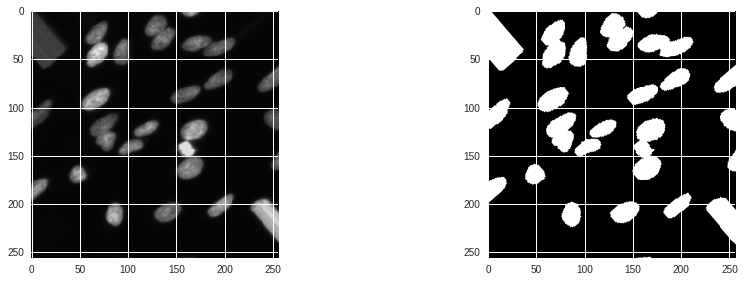

In [0]:
t1 = train[0][6].reshape(256,256,3)
m1 = mask[0][6].reshape(256,256)
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.imshow(t1, cmap='gray')
plt.subplot(222)
_ = plt.imshow(m1, cmap='gray')

## Model training

### Grid Search

**Epochs and Batch Size**

Best result: 
 - Batch size: 8
 - Epochs: 6
 - validation size: 0.1
 - Leds to a result of 0.451843 val_iou
[8, 6, 0.1, 0.4518430228553601]

In [0]:
early_stopping = EarlyStopping(monitor='val_iou', min_delta=0, patience=10, verbose=1, mode='auto') #patience 10 because it wouldn't test anything.
checkpoint = ModelCheckpoint('not_augmented_%sepochs_%ssteps_%batchsize.hdf5', monitor='val_iou', verbose=0, save_best_only=True, mode='max')
callbacks = [checkpoint, early_stopping]

results = list() # lists of 4 numb
grid_batch_size = [8,16,24,32]
grid_epochs = [3,6,9]
grid_validation_size = [0.1, 0.2]

for batch_size in grid_batch_size:
  for epochs_g in grid_epochs:
    for validation_size in grid_validation_size:
      model = models[model_choice]()
      print("GridSearch: [ batch size %i -- epochs %s -- validation size %s ]" %(batch_size, epochs_g, validation_size))
      _ = model.fit(np.array(X_train), np.array(Y_train), validation_split=validation_size, batch_size=batch_size, epochs=epochs_g, callbacks=callbacks, verbose=0)
      validation_iou = max(model.history.history['val_iou'])
      results.append([batch_size, epochs_g, validation_size, validation_iou])

print(results)

### Augmented training

In [25]:
#@title Parameter configuration { vertical-output: true, form-width: "50%", display-mode: "form" }
epochs = 3 #@param {type:"integer", min:1, max:100, step:1}
steps_per_epoch = 72 #@param {type:"integer", min:0, max:10000, step:1}

# tsboard = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=64, write_graph=True,
#                             write_grads=False,
#                             write_images=False, embeddings_freq=0, embeddings_layer_names=None,
#                             embeddings_metadata=None)

early_stopping = EarlyStopping(monitor='val_iou', min_delta=0, patience=3, verbose=1, mode='auto')
checkpoint = ModelCheckpoint('augmented_%sepochs_%ssteps.hdf5', monitor='val_iou', verbose=1, save_best_only=True, mode='max')
callbacks = [checkpoint, early_stopping]
train_generator, validation_generator = get_data_augmentation_generators(8)

_ = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=12,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1)

Epoch 1/3
72/72 [==============================] - 107s 1s/step - loss: 0.6754 - iou: 0.0000e+00 - val_loss: 0.6737 - val_iou: 0.0000e+00

Epoch 00001: val_iou improved from -inf to 0.00000, saving model to augmented_%sepochs_%ssteps.hdf5
Epoch 2/3
 1/72 [..............................] - ETA: 1:35 - loss: 0.6743 - iou: 0.0000e+00

KeyboardInterrupt: ignored

In [0]:
# updatable plot
# a minimal example (sort of)
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_batch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('iou'))
        self.val_losses.append(logs.get('val_iou'))
        self.i += 1
        axes = plt.gca()
        axes.set_ylim([0,1])
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="iou")
        plt.plot(self.x, self.val_losses, label="val_iou")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

### Simple training
Training with just the given images.

In [44]:
#@title Simple training { form-width: "20%", display-mode: "form" }
epochs = 100 #@param {type:"integer"}
validation_size = 0.1 #@param {type:"number"}
batch_size = 16 #@param {type:"integer"}

early_stopping = EarlyStopping(monitor='val_iou', min_delta=0, patience=3, verbose=1, mode='auto')
checkpoint = ModelCheckpoint('not_augmented_%sepochs_%ssteps_%batchsize.hdf5', monitor='val_iou', verbose=1, save_best_only=True, mode='max')
callbacks = [checkpoint, early_stopping]

_ = model.fit(np.array(X_train), np.array(Y_train), validation_split=validation_size, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=1)

Train on 603 samples, validate on 67 samples
Epoch 1/100
603/603 [==============================] - 96s 160ms/step - loss: 0.1224 - iou: 0.3387 - val_loss: 0.1027 - val_iou: 0.4383

Epoch 00001: val_iou improved from -inf to 0.43834, saving model to not_augmented_%sepochs_%ssteps_%batchsize.hdf5
Epoch 2/100
603/603 [==============================] - 96s 160ms/step - loss: 0.1132 - iou: 0.3720 - val_loss: 0.0982 - val_iou: 0.4431

Epoch 00002: val_iou improved from 0.43834 to 0.44311, saving model to not_augmented_%sepochs_%ssteps_%batchsize.hdf5
Epoch 3/100
603/603 [==============================] - 97s 160ms/step - loss: 0.1005 - iou: 0.4076 - val_loss: 0.0858 - val_iou: 0.4482

Epoch 00003: val_iou improved from 0.44311 to 0.44825, saving model to not_augmented_%sepochs_%ssteps_%batchsize.hdf5
Epoch 4/100
603/603 [==============================] - 96s 160ms/step - loss: 0.0932 - iou: 0.4403 - val_loss: 0.0817 - val_iou: 0.4839

Epoch 00004: val_iou improved from 0.44825 to 0.48387, s

In [0]:
model.load_weights(filepath='./augmented_%sepochs_%ssteps.hdf5')

KeyError: ignored

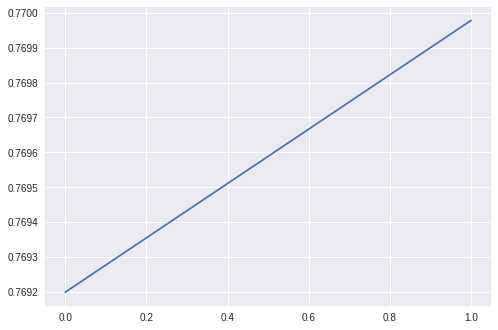

In [0]:
history = model.history
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
from copy import copy
predictions = model.predict(np.array(test))

#upsample
upsampled_predictions = list()
for i, p in enumerate(predictions):
  test_image = copy(test_r.Pixels.values[i].astype(np.float32))
  test_shape_x, test_shape_y, _ = test_image.shape
  x = copy(predictions[i]) #* 255.0
  #   x[x==1] = 255
  #   x[x<1] = 0
  x = x.reshape(256,256)
  x = misc.imresize(x, (test_shape_x, test_shape_y))
  #   x = grey_dilation(grey_erosion(x, size=(8,8)), size=(6,6))
  upsampled_predictions.append(x)

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


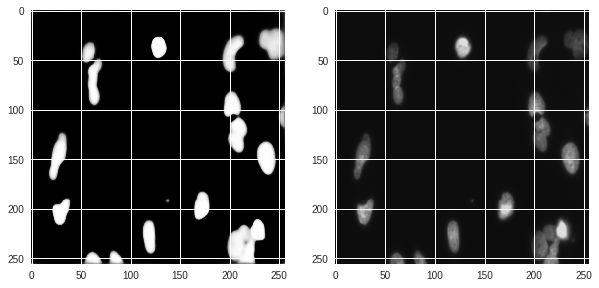

In [46]:
from scipy.ndimage.morphology import grey_erosion, grey_dilation

predicted_image = copy(upsampled_predictions[62])
erosed_image = grey_dilation(grey_erosion(copy(predicted_image), size=(8,8)), size=(6,6))
_ = plt.figure(figsize=(10,15))
_ = plt.subplot(221)
_ = plt.imshow(predicted_image, cmap='gray')
_ = plt.subplot(222)
_ = plt.imshow(test_r.Pixels.values[62], cmap='gray')
# _ = plt.subplot(223)
# _ = plt.imshow(erosed_image, cmap='gray')
# _ = plt.subplot(223)
# _ = plt.imshow(predictions[15].reshape(128,128), cmap='gray')

plt.show()

In [54]:
iou_metric(test_r.Pixels.values[62], predicted_image)

ValueError: ignored

In [0]:
print(label((predicted_image)>180).max())

17


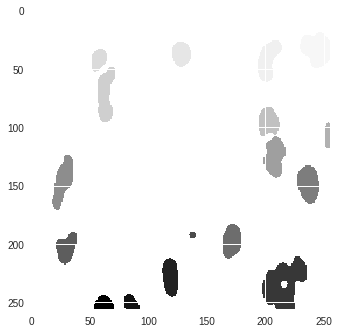

In [0]:
ims = label(predicted_image>150)
_ = plt.imshow(ims)

In [0]:
predicted_image/255

array([[0.24313725, 0.20784314, 0.31372549, ..., 0.77254902, 0.69803922,
        0.63137255],
       [0.14117647, 0.10196078, 0.15686275, ..., 0.94117647, 0.89803922,
        0.72941176],
       [0.10196078, 0.05490196, 0.08627451, ..., 0.95686275, 0.92941176,
        0.76470588],
       ...,
       [0.36078431, 0.38823529, 0.5254902 , ..., 0.1254902 , 0.21960784,
        0.31372549],
       [0.37647059, 0.34901961, 0.4627451 , ..., 0.27843137, 0.41568627,
        0.43137255],
       [0.42352941, 0.36470588, 0.41960784, ..., 0.34117647, 0.40392157,
        0.43529412]])

In [48]:

regions = [label(up > 128) for up in upsampled_predictions]
regions[25].max()

59

In [0]:
# run-length
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

rle_mask = list()
for id_, r in zip(test_r.ImageId.values, regions):
  for i in range(1, r.max() + 1):
    rle_mask.append([id_,rle_encoding(r == i)])

submission = pd.DataFrame(np.array(rle_mask, dtype=object), columns=["ImageId", "EncodedPixels"])
submission['EncodedPixels'] = pd.Series(submission.EncodedPixels.values).apply(lambda x: ' '.join(str(y) for y in x))
submission.to_csv("iou_grid4_submission.csv", index=False)
  
# rles = [rle_encoding(up) for up in upsampled_predictions]



    
# # Create submission DataFrame
# sub = pd.DataFrame()
# sub['ImageId'] = test_r.ImageId.values #Revisar el orden cojones!
# sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))

# fname ='iou3_submission.csv'

# sub.to_csv(fname, index=False)

# sub.head()

In [50]:
submission.head()

,ImageId,EncodedPixels
0,9ab2d381f90b485a68b82bc07f94397a0373e3215ad209...,49674 4 49926 13 50180 18 50434 23 50690 25 50...
1,9ab2d381f90b485a68b82bc07f94397a0373e3215ad209...,28200 5 28454 9 28708 14 28963 17 29218 20 294...
2,9ab2d381f90b485a68b82bc07f94397a0373e3215ad209...,51816 10 52068 16 52322 19 52576 23 52831 25 5...
3,ab298b962a63e4be9582513aaa84a5e270adba5fd2b16a...,41219 7 41474 9 41729 11 41985 12 42241 12 424...
4,ab298b962a63e4be9582513aaa84a5e270adba5fd2b16a...,57437 6 57692 8 57948 9 58204 10 58460 10 5871...


In [51]:
len(submission.ImageId.values)

1713

In [0]:
from google.colab import files

files.download("iou_grid4_submission.csv")

In [0]:
count = 0
for i,p in enumerate(predictions):
  x,y,z = np.where(p==1)
  if len(x) == 0 or len(y) == 0:
    count +=1 
print("%s empty out of %s" %(count, i))

65 empty out of 64


In [0]:
i,j = np.where( x==1)
for a,b in zip(i,j):
  print(a,b)

In [0]:
from scipy import ndimage
from copy import copy

[]


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


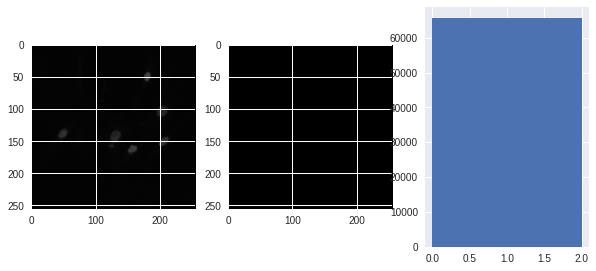

In [0]:
test_image = copy(test.Pixels.values[6])
test_shape_x, test_shape_y, _ = test_image.shape
x = copy(predictions[6]) #* 255.0
print(x[x==1])
x[x<1] = 0
x[x==1] = 255
x = x.reshape(256,256)
x = misc.imresize(x, (test_shape_x, test_shape_y))
# x = ndimage.binary_erosion(x, iterations=1)

_ = plt.figure(figsize=(10,15))
_ = plt.subplot(331)
_ = plt.imshow(test_image, cmap='gray')
_ = plt.subplot(332)
_ = plt.imshow(x, cmap='gray')
_ = plt.subplot(333)
_ = plt.hist(x.ravel(), [0,2])
_ = plt.show()

[1. 1. 1. ... 1. 1. 1.]
